Reinforcement Learning : Stock Trading Final Project

In [1]:
# This file implements an environment in which an RL agent can learn to trade
# stocks. The environment is based on the OpenAI gym API.
# and uses the Yahoo Finance API to get stock data.

In [2]:
# Environment requirements: python 3.10
# brew install pyenv
# pyenv install 3.10.12
# pyenv global 3.10.12

In [3]:
# TODO
# Concept of time
#   - updating portfolio value for each stock
#   - updating stock prices
#   - store a history of stock prices for each stock (helpful for plotting)
#   - store a history of portfolio value (helpful for plotting)

# Allowed actions
#  - do we actually have enough money to buy the stock?

SECTION 1 : PIP INSTALLS, REQUIRED PACKAGES, AND SETUP

In [4]:
# Necessary imports (from FinRL Tutorial)
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
# import condacolab
# condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

zsh:1: command not found: apt-get
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/h9/xg1dvqnj3j5cx54f20x3t_kr0000gn/T/pip-req-build-2llcoacr
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/h9/xg1dvqnj3j5cx54f20x3t_kr0000gn/T/pip-req-build-2llcoacr
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit df93fa44021d206274847faff744ca9f51891d7c
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/h9/xg1dvqnj3j5cx54f20x3t_kr0000gn/T/pip-install-u0qv4cnl/elegantrl_7c3a60d8419e4911819334e9f1b2a114
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/h9/xg1dvqnj3j5cx54f20x3t_kr0000gn/T/pip-install-u0qv4cnl/elegantrl_7c

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

!pip install pandas_market_calendars
import pandas_market_calendars as mcal


from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
!pip install gym
import gym
from gym import spaces
!pip install 'shimmy>=2.0'


/Users/jeremyboyd/finrl_env/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827623 sha256=e4bbc8772b0de5083ab9d69108d5a01bf2dd2b55ab064760db2649650fee87ac
  Stored in directory: /Users/jeremyboyd/Library/Caches/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym


In [6]:
# create folders to save the data
import os

if not os.path.exists("./datasets"): 
  os.makedirs("./datasets") 
if not os.path.exists("./trained_models"): 
  os.makedirs("./trained_models") 
if not os.path.exists("./tensorboard_log"): 
  os.makedirs("./tensorboard_log") 
if not os.path.exists("./results"): 
  os.makedirs("./results") 

SECTION 2 : FORMATTING DATES TO DOWNLOAD, SAMPLE DATA

In [7]:
# # Only consider valid dates
# nyse = mcal.get_calendar('NYSE')
# schedule = nyse.schedule(start_date=TRAIN_START_DATE, end_date=TRADE_END_DATE)
# date_range = schedule.index.strftime('%Y-%m-%d')  # Valid trading days


In [8]:
# Define a class that loads the stock data and creates the environment

class DataLoader():
    def __init__(self, stock_names, start_date, end_date):
        self.stock_names = stock_names
        self.start_date = start_date
        self.end_date = end_date
        self.df = self.download_data()

    def download_data(self):
        df = YahooDownloader(start_date = self.start_date,
                            end_date = self.end_date,
                            ticker_list = self.stock_names).fetch_data()

        return df

In [9]:
# Use the date range alongside yahoo finance to download the data
STOCKS = ['AAPL', 'MSFT']
# Define your parameters
TRAIN_START_DATE = '2020-01-01'
TRADE_END_DATE = '2021-01-01'
TIME_INTERVAL = '1D'

data = DataLoader(stock_names=STOCKS, start_date=TRAIN_START_DATE, end_date=TRADE_END_DATE)

# Print the end of the data
data.df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (506, 8)


,date,open,high,low,close,volume,tic,day
501,2020-12-29,216.667450,224.149994,227.179993,226.309998,17403200,MSFT,1
502,2020-12-30,130.758743,133.720001,135.990005,135.580002,96452100,AAPL,2
503,2020-12-30,214.279907,221.679993,225.630005,225.229996,20272300,MSFT,2
504,2020-12-31,129.751617,132.690002,134.740005,134.080002,99116600,AAPL,3
505,2020-12-31,214.995178,222.419998,223.000000,221.699997,20942100,MSFT,3


In [10]:
print(data.df)



           date        open        high         low       close     volume  \
0    2020-01-02   72.796013   75.087502   75.150002   74.059998  135480400   
1    2020-01-02  153.630707  160.619995  160.729996  158.779999   22622100   
2    2020-01-03   72.088287   74.357498   75.144997   74.287498  146322800   
3    2020-01-03  151.717773  158.619995  159.949997  158.320007   21116200   
4    2020-01-06   72.662720   74.949997   74.989998   73.447502  118387200   
..          ...         ...         ...         ...         ...        ...   
501  2020-12-29  216.667450  224.149994  227.179993  226.309998   17403200   
502  2020-12-30  130.758743  133.720001  135.990005  135.580002   96452100   
503  2020-12-30  214.279907  221.679993  225.630005  225.229996   20272300   
504  2020-12-31  129.751617  132.690002  134.740005  134.080002   99116600   
505  2020-12-31  214.995178  222.419998  223.000000  221.699997   20942100   

      tic  day  
0    AAPL    3  
1    MSFT    3  
2    AAPL   

SECTION 3 : SETUP CLASSES (MARKET, PORTFOLIO, STOCKTRADING)

In [11]:
# keeps track of current investment in each stock
# include methods for:
# - total investment
# - investment in each stock
# - investment in each stock as a percentage of total investment
# - buy/sell stock
#   visualize investment
# create random portfolio


# State of portfolio should be:
#   - how many shares of each stock we have
#   - value of each stock
#   - how much money we have left


class Portfolio:
    
    BUY = 1
    SELL = -1
    HOLD = 0

    def __init__(self, stocks, initial_balance = 10000):
        
        # Stocks is a list of stock symbols
        # Not necessarily those that we have purchased, but those that we are considering
        # for purchase
        self.stocks = stocks


        # How much money we have invested in each stock
        self.investment = {stock: 0 for stock in stocks}

        # How many shares we have in each stock
        self.investment_shares = {stock: 0 for stock in stocks}

        # Total amount of money invested
        self.total_investment = 0

        # Percentage of total investment in each stock
        self.investment_percentage = {stock: 0 for stock in stocks}

        # Total balance (how much money we have left)
        self.balance = initial_balance

        # Initial balance (how much money we started with)
        self.initial_balance = initial_balance

    def reset(self):
        self.investment = {stock: 0 for stock in self.stocks}
        self.total_investment = 0
        self.investment_percentage = {stock: 0 for stock in self.stocks}
        self.balance = self.initial_balance

    def allowed_actions(self):
        return [Portfolio.BUY, Portfolio.SELL, Portfolio.HOLD]


    def take_action(self, action, stock, amount):
        if action == Portfolio.BUY:
            self.buy(stock, amount)
        elif action == Portfolio.SELL:
            self.sell(stock, amount)
        else:
            self.hold(stock)

    # Buy a stock in dollars, updating our portfolio
    def buy(self, stock, amount, price):
        if amount < 0:
            amount = 0
            # raise ValueError("Cannot buy negative amount of stock")
        if amount > self.balance:
            amount = self.balance
            # raise ValueError("Cannot buy more stock than we have money for")

        self.investment[stock] += amount
        self.total_investment += amount

        # update shares
        self.investment_shares[stock] += self.investment[stock] / price

        self.update_investment_percentage()

    def sell(self, stock, amount, price):
        if amount < 0:
            amount = 0
            # raise ValueError("Cannot sell negative amount of stock")
        if amount > self.investment[stock]:
            amount = self.investment[stock]
            # raise ValueError("Cannot sell more stock than we have")
        self.investment[stock] -= amount
        self.total_investment -= amount

        # update shares
        self.investment_shares[stock] -= self.investment[stock] / price
        
        self.update_investment_percentage()


    def update_investment_percentage(self):
        for stock in self.stocks:
            # check division by zero
            if self.total_investment == 0:
                self.investment_percentage[stock] = 0
            else:
              self.investment_percentage[stock] = self.investment[stock] / self.total_investment


    def hold(self, stock):
        return self.investment[stock]
    
    def visualize(self):
        plt.bar(self.stocks, self.investment.values())
        plt.show()

    def random_portfolio(self):
        for stock in self.stocks:
            self.buy(stock, np.random.randint(0, 1000))


    def report(self):
        print(f"Total investment: {self.total_investment}")
        print(f"Total balance: {self.balance}")
        print(f"Total value: {self.total_investment + self.balance}")
        print(f"Percentage of total investment in each stock: {self.investment_percentage}")

        # print investment in each stock
        print(f"Investment in each stock: {self.investment}")

        # print number of shares in each stock
        print(f"Number of shares in each stock: {self.investment_shares}")
    

        print("Investment Values: ", self.investment.values())
        print("Investment keys: ", self.investment.keys())

        # Convert values to a list
        investment_values = list(self.investment.values())
        investment_keys = list(self.investment.keys())

        # Ensure there are no issues with the data
        if sum(investment_values) == 0:
            raise ValueError("Investment values sum to zero, cannot plot pie chart.")

        # Plot portfolio as a pie chart
        fig, ax = plt.subplots()
        ax.pie(investment_values, labels=investment_keys, autopct='%1.1f%%')
        plt.show()
        

In [12]:
# Market class

# This class holds the stock data and the current state of the market
# This is independent of our agent/porfolio class but the agent interacts with it

# it can be queried for the current price of a stock, the current state of the market, and the current state of the agent

# The state of the market should be the data for the current day
# for every stock in the stock list, we should have the open, close, high, low, volume, and adjusted close

class Market:
    def __init__(self, stock_data, window_size):
        self.stock_data = stock_data
        self.current_step = 0
        self.done = False
        self.history = []
        self.state = self.get_state()
        self.reward = 0


    def get_price_at_step(self, stock, step):
        return self.stock_data.loc[(self.stock_data.index[step], stock), 'Close']


    # Return the state of the market with day=current_step
    def get_state(self):
        
        # Get close price for each stock where day=current_step
        state = {'tic': [], 'close': []}
        # current_date = self.stock_data.index[self.current_step]

        for stock in STOCKS:
            state['tic'].append(stock)
            state['close'].append(self.get_price_at_step(stock, self.current_step))

        print("State in get_state: ", state)
        return state


    
    def get_price(self, stock):
        return self.get_price_at_step(stock, self.current_step)

    

    def get_price_at_step(self, stock, step):
        print("trying to get price at step")
        offset_date = self.stock_data['date'].iloc[step]
        print("Offset date: ", offset_date)
        close_value = self.stock_data.loc[(self.stock_data['date'] == offset_date) & (self.stock_data['tic'] == stock), 'close'].values[0]
        return close_value

    
    def get_reward(self):
        return self.reward

    def reset(self):
        self.current_step = 0
        self.done = False
        self.history = []
        self.state = self.get_state()
        self.reward = 0

In [18]:
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, market, portfolio, initial_balance=10000):
        super(StockTradingEnv, self).__init__()

        self.market = market
        self.portfolio = portfolio
        self.initial_balance = initial_balance

        # cash balance
        self.current_balance = initial_balance

        # total monetary value of the portfolio
        self.portfolio_value = 0

        self.current_step = 0
        self.done = False

        # Define action and observation space
        # Actions: Buy, Sell, Hold for each stock
        num_stocks = len(self.market.stock_data['tic'].unique())
        self.action_space = spaces.MultiDiscrete([num_stocks, 3, 100])

        # Observations: State of the market and portfolio
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(num_stocks * 2 + 1,), dtype=np.float32)

    def reset(self):
        self.current_balance = self.initial_balance
        self.current_step = 0
        self.done = False
        self.portfolio.reset()
        self.market.reset()
        return self.get_state()

    def report_portfolio(self):
        return self.portfolio.report()

    def pass_time(self):
        self.current_step += 1
        self.market.current_step += 1
        self.market.state = self.market.get_state()
        self.update_portfolio_value(self.current_step - 1, self.current_step)

    def step(self, action):
        if self.done:
            raise ValueError("The simulation is done. Call reset to start again.")

        stock_idx, act_type, amount = action  # Expecting a tuple (stock_idx, action_type, amount)
        stock = self.market.stock_data['tic'].unique()[stock_idx]

        if act_type == 0:  # Buy
            self.buy_stock(stock, amount)
        elif act_type == 1:  # Sell
            self.sell_stock(stock, amount)

        self.pass_time()

        # reward is offset from ini
        reward = self.portfolio_value + self.current_balance - self.initial_balance
        self.done = self.current_step >= len(self.market.stock_data) - 1

        return self.get_state(), reward, self.done, {}

    def get_state(self):
        # Get close price for each stock where day=current_step
        state = {'tic': [], 'close': []}
        current_date = self.market.stock_data.index[self.current_step]
        for stock in self.market.stock_data['tic'].unique():
            state['tic'].append(stock)
            state['close'].append(self.market.get_price_at_step(stock, self.current_step))

        print("State in get_state: ", state)
        # Ensure the observation matches the expected shape
        observation = np.array(state['close'] + [self.current_balance])
        observation = np.pad(observation, (0, self.observation_space.shape[0] - len(observation)), 'constant')
        return observation

    def curr_portfolio_balance(self):
        # Check the market value of the portfolio
        total_value = 0
        for stock in self.portfolio.stocks:
            total_value += self.market.get_price(stock) * self.portfolio.investment_shares[stock]
        return total_value

    def update_portfolio_value(self, prev_step, current_step):
        print("Value of each stock before: ", self.portfolio.investment)
        for stock in self.portfolio.stocks:
            price_today = self.market.get_price_at_step(stock, prev_step)
            print("Price today: ", price_today)
            price_tomorrow = self.market.get_price_at_step(stock, current_step)
            ratio = price_tomorrow / price_today
            self.portfolio.investment[stock] *= ratio
        self.portfolio_value = self.curr_portfolio_balance()

    def buy_stock(self, stock, amount):
        if amount <= 0:
            amount = 1
        print("trying to buy ", stock, " amount: ", amount)
        price = self.market.get_price(stock)
        total_cost = amount * price
        if total_cost > self.current_balance:
            amount = self.current_balance // price  # Adjust amount to fit the current balance
        self.portfolio.buy(stock, amount, price)
        self.current_balance -= amount * price

    def sell_stock(self, stock, amount):
        if amount <= 0:
            amount = 1
          # raise ValueError("Amount to sell must be positive")
        price = self.market.get_price(stock)
        self.portfolio.sell(stock, amount, price)
        self.current_balance += amount * price

    def render(self, mode='human', close=False):
        # Implement the logic to render the environment
        pass

    def close(self):
        # Implement the logic to close the environment
        pass

# Create instances of Market and Portfolio
data_df = data.df
tickers = ['AAPL', 'MSFT']
market = Market(data_df, window_size=1)
portfolio = Portfolio(stocks=tickers, initial_balance=10000)

# Create the environment
env = StockTradingEnv(market, portfolio)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
Using cpu device


ValueError: The environment is of type <class '__main__.StockTradingEnv'>, not a Gymnasium environment. In this case, we expect OpenAI Gym to be installed and the environment to be an OpenAI Gym environment.

Example model usage

In [17]:
# Create instances of Market and Portfolio
data_df = data.df
tickers = ['AAPL', 'MSFT']
market = Market(data_df, window_size=1)
portfolio = Portfolio(stocks=tickers, initial_balance=10000)

# Create the environment
env = StockTradingEnv(market, portfolio)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
Using cpu device


ValueError: The environment is of type <class '__main__.StockTradingEnv'>, not a Gymnasium environment. In this case, we expect OpenAI Gym to be installed and the environment to be an OpenAI Gym environment.

trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
Value of each stock before:  {'AAPL': 0, 'MSFT': 0}
trying to get price at step
Offset date:  2020-01-02
Price today:  74.05999755859375
trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
Price today:  158.77999877929688
trying to get price at step
Offset date:  2020-01-02
trying to

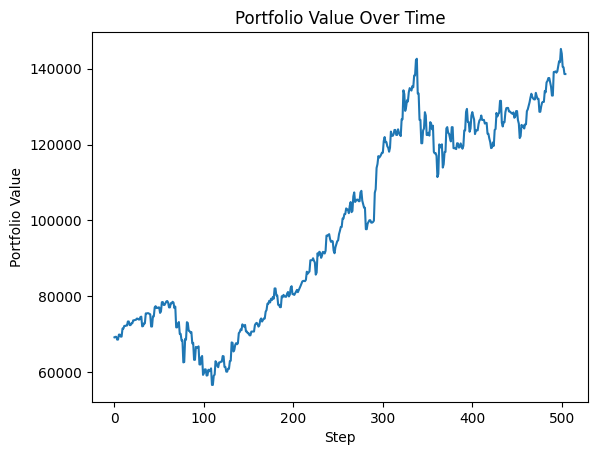

In [156]:
# After training, we can test the model
# Step 4: Simulate trading and track portfolio value
def simulate_trading(env, model):
    portfolio_values = []
    state = env.reset()
    done = False
    while not done:
        action, _ = model.predict(state)
        state, reward, done, _ = env.step(action)
        portfolio_values.append(env.portfolio_value)
    return portfolio_values

# Simulate trading
portfolio_values = simulate_trading(env, model)

# Plot the portfolio values
plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.show()

Total investment: 700.6115510245099
Total balance: 10000
Total value: 10700.61155102451
Percentage of total investment in each stock: {'AAPL': 1.7563716796359545, 'MSFT': 0.15793375159701378}
Investment in each stock: {'AAPL': 1216.9201739071098, 'MSFT': 108.91600511567668}
Number of shares in each stock: {'AAPL': 839.8924916448816, 'MSFT': 117.18535298047458}
Investment Values:  dict_values([1216.9201739071098, 108.91600511567668])
Investment keys:  dict_keys(['AAPL', 'MSFT'])


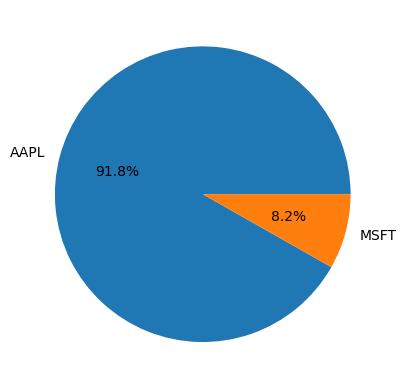

In [157]:
# Print a pie chart of the portfolio
env.report_portfolio()

SECTION 4 : SMALL TESTING OF BUYING AND SELLING STOCK

In [148]:
# 1.) Setup our data
data_df = data.df

print(type(data_df))

# 2.) Setup a portfolio
stocks = ['AAPL', 'MSFT']
portfolio = Portfolio(stocks, 10000)

# 3.) Setup the market
market = Market(data_df, 10)

# 4.) Setup the environment
env = StockTradingEnv(market, portfolio)

<class 'pandas.core.frame.DataFrame'>
trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}


EXAMPLE BUYING AND SELLING STOCK

trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
trying to buy  AAPL  amount:  5000
trying to get price at step
Offset date:  2020-01-02
trying to buy  MSFT  amount:  5000
trying to get price at step
Offset date:  2020-01-02
Total investment: 135.0
Total balance: 10000
Total value: 10135.0
Percentage of total investment in each stock: {'AAPL': 1.0, 'MSFT': 0.0}
Investment in each stock: {'AAPL': 135.0, 'MSFT': 0.0}
Number of shares in each stock: {'AAPL': 1.8228464008953362, 'MSFT': 0.0}
Investment Values:  dict_values([135.0, 0.0])
Investment keys:  dict_keys(['AAPL', 'MSFT'])


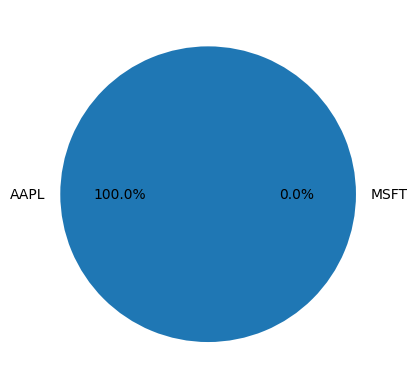

trying to get price at step
Offset date:  2020-01-02
Total investment: 0.0
Total balance: 10000
Total value: 10000.0
Percentage of total investment in each stock: {'AAPL': 0, 'MSFT': 0}
Investment in each stock: {'AAPL': 0.0, 'MSFT': 0.0}
Number of shares in each stock: {'AAPL': 1.8228464008953362, 'MSFT': 0.0}
Investment Values:  dict_values([0.0, 0.0])
Investment keys:  dict_keys(['AAPL', 'MSFT'])


ValueError: Investment values sum to zero, cannot plot pie chart.

In [149]:
env.reset()

# Buy some stock
# env.portfolio.take_action(Portfolio.BUY, 'AAPL', 5000)
env.buy_stock('AAPL', 5000)
env.buy_stock('MSFT', 5000)

# env.portfolio.take_action(Portfolio.BUY, 'MSFT', 5000)

# Report the portfolio
env.report_portfolio()

# # Sell some stock
# env.portfolio.take_action(Portfolio.SELL, 'AAPL', 1000)
env.sell_stock('AAPL', 1000)
env.report_portfolio()


EXAMPLE TIME PASSED

In [16]:
env.reset()

# Buy some stock
env.buy_stock('AAPL', 5000)
env.buy_stock('MSFT', 5000)


# Report the portfolio
env.report_portfolio()

# Time passes
for i in range(100):
    env.pass_time()

# Report the portfolio
env.report_portfolio()

/var/folders/yk/k52f9tb16wl2cspty5xjt0m00000gn/T/ipykernel_2909/2230431995.py:131: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
trying to buy  AAPL  amount:  5000
trying to get price at step
Offset date:  2020-01-02
trying to buy  MSFT  amount:  5000
trying to get price at step
Offset date:  2020-01-02
Total investment: 10000
Total balance: 10000
Total value: 20000
Percentage of total investment in each stock: {'AAPL': 0.5, 'MSFT': 0.5}
Investment in each stock: {'AAPL': 5000, 'MSFT': 5000}
Number of shares in each stock: {'AAPL': 81.01539559534827, 'MSFT': 62.980224693791136}
Investment Values:  dict_values([5000, 5000])
Investment keys:  dict_keys(['AAPL', 'MSFT'])
trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}
Value of each stock before:  {'AAPL': 5000, 'M

In [17]:
# 1.) Setup our data
data_df = data.df

print(type(data_df))

# 2.) Setup a portfolio
stocks = ['AAPL', 'MSFT']
portfolio = Portfolio(stocks, 10000)

# 3.) Setup the market
market = Market(data_df, 10)

# 4.) Setup the environment
env = StockTradingEnv(market, portfolio)

<class 'pandas.core.frame.DataFrame'>
trying to get price at step
Offset date:  2020-01-02
trying to get price at step
Offset date:  2020-01-02
State in get_state:  {'tic': ['AAPL', 'MSFT'], 'close': [74.05999755859375, 158.77999877929688]}


In [20]:
env = StockTradingEnv(market, portfolio)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device


ValueError: The environment is of type <class '__main__.StockTradingEnv'>, not a Gymnasium environment. In this case, we expect OpenAI Gym to be installed and the environment to be an OpenAI Gym environment.

In [ ]:
def simulate_trading(env, model):
    state = env.reset()
    portfolio_values = [env.portfolio_value + env.current_balance]

    done = False
    while not done:
        action = model.predict(state)  # Replace with your model's action logic
        state, reward, done, _ = env.step(action)
        portfolio_values.append(env.portfolio_value + env.current_balance)

    return portfolio_values


*********************100%***********************]  5 of 5 completed

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 251       |
|    ep_rew_mean     | -1.18e+03 |
| time/              |           |
|    fps             | 341       |
|    iterations      | 1         |
|    time_elapsed    | 5         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 251          |
|    ep_rew_mean          | 7.41e+03     |
| time/                   |              |
|    fps                  | 266          |
|    iterations           | 2            |
|    time_elapsed         | 15           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0034266063 |
|    clip_fraction        | 0.189        |
|    clip_range           | 0.1         

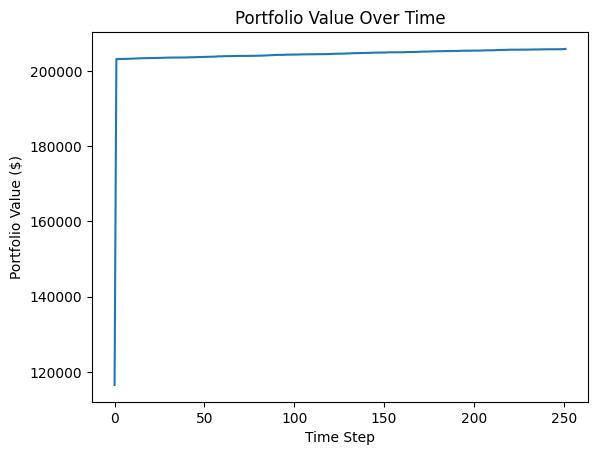

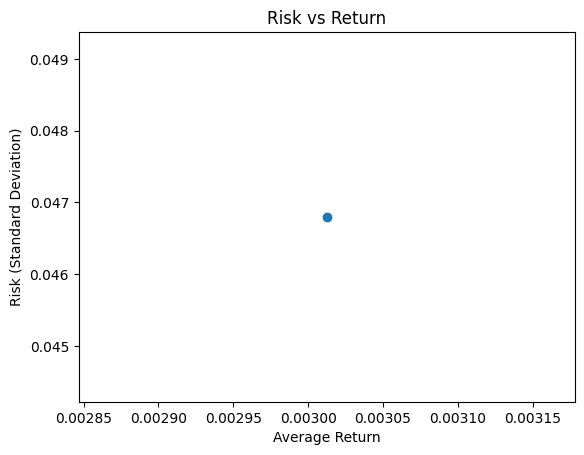

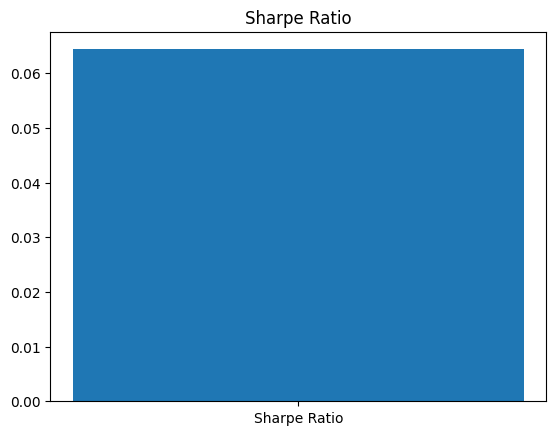

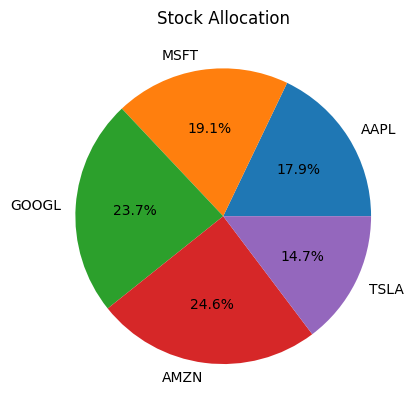

In [21]:
import gymnasium as gym
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gymnasium.spaces import Discrete, Box
import pandas as pd

%matplotlib inline

# Define the tickers and date range
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
start_date = '2015-01-01'
end_date = '2016-01-01'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
init_bal = 10000


class Portfolio:
    BUY = 1
    SELL = -1
    HOLD = 0

    def __init__(self, stocks, initial_balance=10000):
        self.stocks = stocks
        self.investment = {stock: 0 for stock in stocks}
        self.investment_shares = {stock: 0 for stock in stocks}
        self.total_investment = 0
        self.investment_percentage = {stock: 0 for stock in stocks}
        self.balance = initial_balance
        self.initial_balance = initial_balance

    def reset(self):
        self.investment = {stock: 0 for stock in self.stocks}
        self.total_investment = 0
        self.investment_percentage = {stock: 0 for stock in self.stocks}
        self.balance = self.initial_balance

    def allowed_actions(self):
        return [Portfolio.BUY, Portfolio.SELL, Portfolio.HOLD]

    def take_action(self, action, stock, amount, price):
        if action == Portfolio.BUY:
            self.buy(stock, amount, price)
        elif action == Portfolio.SELL:
            self.sell(stock, amount, price)
        else:
            self.hold(stock)

    def buy(self, stock, amount, price):
        if self.balance >= amount * price:
            self.investment[stock] += amount
            self.total_investment += amount
            self.investment_shares[stock] += amount
            self.balance -= amount * price
        self.update_investment_percentage()

    def sell(self, stock, amount, price):
        if self.investment[stock] >= amount:
            self.investment[stock] -= amount
            self.total_investment -= amount
            self.investment_shares[stock] -= amount
            self.balance += amount * price
        self.update_investment_percentage()

    def update_investment_percentage(self):
        for stock in self.stocks:
            if self.total_investment > 0:
                self.investment_percentage[stock] = self.investment[stock] / self.total_investment

    def hold(self, stock):
        return self.investment[stock]

    def report(self):
        print(f"Total investment: {self.total_investment}")
        print(f"Total balance: {self.balance}")
        print(f"Total value: {self.total_investment + self.balance}")
        print(f"Investment in each stock: {self.investment}")
        print(f"Number of shares in each stock: {self.investment_shares}")


class Market:
    def __init__(self, stock_data, window_size):
        self.stock_data = stock_data
        self.window_size = window_size
        self.current_step = 0

    def get_price_at_step(self, stock, step):
        return self.stock_data.iloc[step][stock]

    def get_state(self):
        # Get only the stock prices as the state
        state = [self.get_price_at_step(stock, self.current_step) for stock in self.stock_data.columns]
        return np.array(state)  # Return as a numpy array of stock prices

    def get_price(self, stock):
        return self.get_price_at_step(stock, self.current_step)

    def reset(self):
        self.current_step = 0


class StockTradingEnv(gym.Env):
    def __init__(self, market: Market, portfolio: Portfolio, initial_balance=10000):
        self.market = market
        self.portfolio = portfolio
        self.initial_balance = initial_balance
        self.current_balance = initial_balance
        self.portfolio_value = 0

        # Defining action space for each stock: Buy (1), Sell (-1), Hold (0)
        self.action_space = Discrete(len(self.portfolio.stocks) * 3)  # Three actions for each stock: buy, sell, hold

        # Observation space: stock prices for each stock in the portfolio (using stock prices only)
        self.observation_space = Box(low=0, high=np.inf, shape=(len(self.portfolio.stocks),), dtype=np.float32)

        self.current_step = 0
        self.done = False

    def curr_portfolio_balance(self):
        total_value = 0
        for stock in self.portfolio.stocks:
            total_value += self.market.get_price(stock) * self.portfolio.investment_shares[stock]
        return total_value

    def reset(self, seed=None):
        self.current_balance = self.initial_balance
        self.current_step = 0
        self.done = False
        self.portfolio.reset()
        self.market.reset()
        self.portfolio_value = self.curr_portfolio_balance() + self.current_balance  # Initialize portfolio value
    
        if seed is not None:
            np.random.seed(seed)
    
        state = self.market.get_state()
        info = {}
        return state, info


    def step(self, action):
        stock_idx = action // 3
        action_type = action % 3
    
        stock = self.portfolio.stocks[stock_idx]
        price = self.market.get_price(stock)
        amount = 1
    
        if action_type == Portfolio.BUY:
            self.portfolio.take_action(Portfolio.BUY, stock, amount, price)
        elif action_type == Portfolio.SELL:
            self.portfolio.take_action(Portfolio.SELL, stock, amount, price)
        else:
            self.portfolio.take_action(Portfolio.HOLD, stock, amount, price)
    
        prev_balance = self.curr_portfolio_balance() + self.current_balance
        self.current_balance = self.update_portfolio_value(self.current_step - 1, self.current_step)
        portfolio_value = self.curr_portfolio_balance() + self.current_balance
        reward = portfolio_value - prev_balance
    
        self.current_step += 1
        done = self.current_step >= len(self.market.stock_data) - 1
        truncated = False
    
        return self.market.get_state(), reward, done, truncated, {}


    def update_portfolio_value(self, prev_step, current_step):
        total_value = 0
        for stock in self.portfolio.stocks:
            price_today = self.market.get_price_at_step(stock, prev_step)
            price_tomorrow = self.market.get_price_at_step(stock, current_step)
            ratio = price_tomorrow / price_today
            self.portfolio.investment[stock] *= ratio  # Adjust investment
            total_value += self.market.get_price(stock) * self.portfolio.investment_shares[stock]
        return total_value


# Initialize the portfolio and market
ptflo = Portfolio(tickers, init_bal)
mkt = Market(data, window_size=10)

# Create the environment
env = StockTradingEnv(mkt, ptflo)

# Define the model
model = PPO("MlpPolicy", env,
            learning_rate=0.0001,
            batch_size=32,
            clip_range=0.1,
            gamma=0.98,
            ent_coef=0.05,
            gae_lambda=0.98,
            vf_coef=0.5,
            max_grad_norm=0.5,
            verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Simulate trading
def simulate_trading(env, model):
    state, info = env.reset()  # Get state and info
    portfolio_values = [env.portfolio_value + env.current_balance]
    done = False
    while not done:
        action, _ = model.predict(state)  # Get action from model (ignore the second returned value)
        state, reward, done, truncated, info = env.step(action)  # Make sure to capture all returned values
        portfolio_values.append(env.portfolio_value + env.current_balance)
    return portfolio_values

portfolio_values = simulate_trading(env, model)

# Plot portfolio value over time
plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value ($)")
plt.show()

# 1. Risk vs Return Scatter Plot
returns = np.diff(portfolio_values) / portfolio_values[:-1]
risk = np.std(returns)

plt.scatter(np.mean(returns), risk)
plt.title("Risk vs Return")
plt.xlabel("Average Return")
plt.ylabel("Risk (Standard Deviation)")
plt.show()

# 2. Sharpe Ratio Bar Plot
# Assuming risk-free rate = 0 for simplicity
sharpe_ratio = np.mean(returns) / risk
plt.bar(["Sharpe Ratio"], [sharpe_ratio])
plt.title("Sharpe Ratio")
plt.show()

# 3. Stock Allocation Pie Chart
final_allocation = {stock: ptflo.investment_percentage[stock] for stock in ptflo.stocks}
plt.pie(final_allocation.values(), labels=final_allocation.keys(), autopct='%1.1f%%')
plt.title("Stock Allocation")
plt.show()


In [ ]:
import gymnasium as gym
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gymnasium.spaces import Discrete, Box
import pandas as pd

# Define the tickers and date range
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
start_date = '2015-01-01'
end_date = '2016-01-01'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
init_bal = 10000


class Portfolio:
    BUY = 1
    SELL = -1
    HOLD = 0

    def __init__(self, stocks, initial_balance=10000):
        self.stocks = stocks
        self.investment = {stock: 0 for stock in stocks}
        self.investment_shares = {stock: 0 for stock in stocks}
        self.total_investment = 0
        self.investment_percentage = {stock: 0 for stock in stocks}
        self.balance = initial_balance
        self.initial_balance = initial_balance

    def reset(self):
        self.investment = {stock: 0 for stock in self.stocks}
        self.total_investment = 0
        self.investment_percentage = {stock: 0 for stock in self.stocks}
        self.balance = self.initial_balance

    def allowed_actions(self):
        return [Portfolio.BUY, Portfolio.SELL, Portfolio.HOLD]

    def take_action(self, action, stock, amount, price):
        if action == Portfolio.BUY:
            self.buy(stock, amount, price)
        elif action == Portfolio.SELL:
            self.sell(stock, amount, price)
        else:
            self.hold(stock)

    def buy(self, stock, amount, price):
        if self.balance >= amount * price:
            self.investment[stock] += amount
            self.total_investment += amount
            self.investment_shares[stock] += amount
            self.balance -= amount * price
        self.update_investment_percentage()

    def sell(self, stock, amount, price):
        if self.investment[stock] >= amount:
            self.investment[stock] -= amount
            self.total_investment -= amount
            self.investment_shares[stock] -= amount
            self.balance += amount * price
        self.update_investment_percentage()

    def update_investment_percentage(self):
        for stock in self.stocks:
            if self.total_investment > 0:
                self.investment_percentage[stock] = self.investment[stock] / self.total_investment

    def hold(self, stock):
        return self.investment[stock]

    def report(self):
        print(f"Total investment: {self.total_investment}")
        print(f"Total balance: {self.balance}")
        print(f"Total value: {self.total_investment + self.balance}")
        print(f"Investment in each stock: {self.investment}")
        print(f"Number of shares in each stock: {self.investment_shares}")


class Market:
    def __init__(self, stock_data, window_size):
        self.stock_data = stock_data
        self.window_size = window_size
        self.current_step = 0

    def get_price_at_step(self, stock, step):
        return self.stock_data.iloc[step][stock]

    def get_state(self):
        # Get only the stock prices as the state
        state = [self.get_price_at_step(stock, self.current_step) for stock in self.stock_data.columns]
        return np.array(state)  # Return as a numpy array of stock prices

    def get_price(self, stock):
        return self.get_price_at_step(stock, self.current_step)

    def reset(self):
        self.current_step = 0


class StockTradingEnv(gym.Env):
    def __init__(self, market: Market, portfolio: Portfolio, initial_balance=10000):
        self.market = market
        self.portfolio = portfolio
        self.initial_balance = initial_balance
        self.current_balance = initial_balance
        self.portfolio_value = 0

        # Defining action space for each stock: Buy (1), Sell (-1), Hold (0)
        self.action_space = Discrete(len(self.portfolio.stocks) * 3)  # Three actions for each stock: buy, sell, hold

        # Observation space: stock prices for each stock in the portfolio (using stock prices only)
        self.observation_space = Box(low=0, high=np.inf, shape=(len(self.portfolio.stocks),), dtype=np.float32)

        self.current_step = 0
        self.done = False

    def curr_portfolio_balance(self):
        total_value = 0
        for stock in self.portfolio.stocks:
            total_value += self.market.get_price(stock) * self.portfolio.investment_shares[stock]
        return total_value

    def reset(self, seed=None):
        self.current_balance = self.initial_balance
        self.current_step = 0
        self.done = False
        self.portfolio.reset()
        self.market.reset()
        self.portfolio_value = self.curr_portfolio_balance() + self.current_balance  # Initialize portfolio value
    
        if seed is not None:
            np.random.seed(seed)
    
        state = self.market.get_state()
        info = {}
        return state, info

    def step(self, action):
        stock_idx = action // 3
        action_type = action % 3
    
        stock = self.portfolio.stocks[stock_idx]
        price = self.market.get_price(stock)
        amount = 1
    
        if action_type == Portfolio.BUY:
            self.portfolio.take_action(Portfolio.BUY, stock, amount, price)
        elif action_type == Portfolio.SELL:
            self.portfolio.take_action(Portfolio.SELL, stock, amount, price)
        else:
            self.portfolio.take_action(Portfolio.HOLD, stock, amount, price)
    
        prev_balance = self.curr_portfolio_balance() + self.current_balance
        self.portfolio_value = self.update_portfolio_value(self.current_step - 1, self.current_step)
        portfolio_value = self.curr_portfolio_balance() + self.current_balance
        reward = portfolio_value - prev_balance
    
        self.current_step += 1
        done = self.current_step >= len(self.market.stock_data) - 1
        truncated = False
    
        return self.market.get_state(), reward, done, truncated, {}

    def update_portfolio_value(self, prev_step, current_step):
        total_value = 0
        for stock in self.portfolio.stocks:
            # Directly compute the portfolio value based on current share prices
            price_today = self.market.get_price_at_step(stock, prev_step)
            price_tomorrow = self.market.get_price_at_step(stock, current_step)
            self.portfolio.investment[stock] *= price_tomorrow / price_today  # Adjust investment based on price change
            total_value += self.market.get_price(stock) * self.portfolio.investment_shares[stock]  # Value of shares
        return total_value


# Initialize the portfolio and market
ptflo = Portfolio(tickers, init_bal)
mkt = Market(data, window_size=10)

# Create the environment
env = StockTradingEnv(mkt, ptflo)

# Define the model
model = PPO("MlpPolicy", env,
            learning_rate=0.0001,
            batch_size=32,
            clip_range=0.1,
            gamma=0.98,
            ent_coef=0.05,
            gae_lambda=0.98,
            vf_coef=0.5,
            max_grad_norm=0.5,
            verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Simulate trading
def simulate_trading(env, model):
    state, info = env.reset()  # Get state and info
    portfolio_values = [env.portfolio_value + env.current_balance]
    done = False
    while not done:
        action, _ = model.predict(state)  # Get action from model (ignore the second returned value)
        state, reward, done, truncated, info = env.step(action)  # Make sure to capture all returned values
        portfolio_values.append(env.portfolio_value + env.current_balance)
    return portfolio_values

portfolio_values = simulate_trading(env, model)

# Plot portfolio value over time
plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value ($)")
plt.show()

# 1. Risk vs Return Scatter Plot
returns = np.diff(portfolio_values) / portfolio_values[:-1]
risk = np.std(returns)

plt.scatter(np.mean(returns), risk)
plt.title("Risk vs Return")
plt.xlabel("Average Return")
plt.ylabel("Risk (Standard Deviation)")
plt.show()

# 2. Sharpe Ratio Bar Plot
# Assuming risk-free rate = 0 for simplicity
sharpe_ratio = np.mean(returns) / risk
plt.bar(["Sharpe Ratio"], [sharpe_ratio])
plt.title("Sharpe Ratio")
plt.show()

# 3. Stock Allocation Pie Chart
final_allocation = {stock: ptflo.investment_percentage[stock] for stock in ptflo.stocks}
plt.pie(final_allocation.values(), labels=final_allocation.keys(), autopct='%1.1f%%')
plt.title("Stock Allocation")
plt.show()



*********************100%***********************]  5 of 5 completed

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
